##IMPORTING PACKAGES AND DATASET

In [ ]:
#importing necessary packages 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


from keras import Sequential
from keras.layers import Dense,LSTM
from sklearn.metrics import mean_squared_error,mean_absolute_error
import tensorflow as tf
tf.random.set_seed(2)
from numpy.random import seed
seed(1)


In [ ]:
#To upload CSV file from device
from google.colab import files
data_to_load = files.upload()


Saving FinalProject to FinalProject
Saving fp.csv to fp.csv


###LOADING DATA

In [ ]:
# load dataset
dataset = pd.read_csv('FinalProject', index_col='month')


###PREPARING DATA

In [ ]:
dataset.head()

,energy_used,mean_temp,max_temp,min_temp,vapor_pressure,rain_days,cloud_cover,population,electricity_price,cpi
month,,,,,,,,,,
1973-01-01,1957.641,17.0,0.9,-10.1,4.0,14.3,66.2,211053,2.9,36.5
1973-02-01,1712.143,20.0,4.0,-7.8,4.4,15.8,64.5,211187,2.9,36.7
1973-03-01,1510.079,23.2,9.0,-2.3,6.4,16.1,68.5,211337,2.8,36.9
1973-04-01,1183.421,28.5,13.1,0.8,7.1,11.2,65.1,211499,2.9,37.1
1973-05-01,1006.326,30.0,19.8,6.3,9.5,8.1,60.9,211662,2.8,37.1


In [ ]:
values = dataset.values
values

array([[1.957641e+03, 1.700000e+01, 9.000000e-01, ..., 2.110530e+05,
        2.900000e+00, 3.650000e+01],
       [1.712143e+03, 2.000000e+01, 4.000000e+00, ..., 2.111870e+05,
        2.900000e+00, 3.670000e+01],
       [1.510079e+03, 2.320000e+01, 9.000000e+00, ..., 2.113370e+05,
        2.800000e+00, 3.690000e+01],
       ...,
       [1.331488e+03, 2.500000e+01, 1.740000e+01, ..., 3.193670e+05,
        1.260000e+01, 2.066670e+02],
       [1.773941e+03, 2.160000e+01, 8.100000e+00, ..., 3.195610e+05,
        1.248000e+01, 2.028890e+02],
       [2.164815e+03, 1.750000e+01, 5.400000e+00, ..., 3.197420e+05,
        1.217000e+01, 2.042750e+02]])

In [ ]:
#Scale the data

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
scaled[0]

array([0.55380001, 0.08333333, 0.0751634 , 0.06859206, 0.06      ,
       0.68152866, 0.79146919, 0.        , 0.02859867, 0.        ])

In [ ]:
#convert data to supervised form

def to_supervised(dataset,dropNa = True,lag = 1):
    df = pd.DataFrame(dataset)
    column = []
    column.append(df)
    for i in range(1,lag+1):
        column.append(df.shift(-i))
    df = pd.concat(column,axis=1)
    df.dropna(inplace = True)
    features = dataset.shape[1]
    df = df.values
    supervised_data = df[:,:features*lag]
    supervised_data = np.column_stack( [supervised_data, df[:,features*lag]])
    return supervised_data

In [ ]:
timeSteps = 3

supervised = to_supervised(scaled,lag=timeSteps)
pd.DataFrame(supervised).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,0.553800,0.083333,0.075163,0.068592,0.060000,0.681529,0.791469,0.000000,0.028599,0.000000,0.425046,0.291667,0.176471,0.151625,0.086667,0.777070,0.710900,0.001233,0.028599,0.001102,0.319071,0.513889,0.339869,0.350181,0.220000,0.796178,0.900474,0.002613,0.019066,0.002205,0.147752
1,0.425046,0.291667,0.176471,0.151625,0.086667,0.777070,0.710900,0.001233,0.028599,0.001102,0.319071,0.513889,0.339869,0.350181,0.220000,0.796178,0.900474,0.002613,0.019066,0.002205,0.147752,0.881944,0.473856,0.462094,0.266667,0.484076,0.739336,0.004103,0.028599,0.003307,0.054872
2,0.319071,0.513889,0.339869,0.350181,0.220000,0.796178,0.900474,0.002613,0.019066,0.002205,0.147752,0.881944,0.473856,0.462094,0.266667,0.484076,0.739336,0.004103,0.028599,0.003307,0.054872,0.986111,0.692810,0.660650,0.426667,0.286624,0.540284,0.005603,0.019066,0.003307,0.006949
3,0.147752,0.881944,0.473856,0.462094,0.266667,0.484076,0.739336,0.004103,0.028599,0.003307,0.054872,0.986111,0.692810,0.660650,0.426667,0.286624,0.540284,0.005603,0.019066,0.003307,0.006949,0.902778,0.866013,0.851986,0.706667,0.165605,0.469194,0.007130,0.000000,0.004409,0.031558
4,0.054872,0.986111,0.692810,0.660650,0.426667,0.286624,0.540284,0.005603,0.019066,0.003307,0.006949,0.902778,0.866013,0.851986,0.706667,0.165605,0.469194,0.007130,0.000000,0.004409,0.031558,0.756944,0.944444,0.938628,0.846667,0.108280,0.232227,0.008722,0.000000,0.004409,0.048544


In [ ]:
# spiltting the data
# training on only first 31 years data
features = dataset.shape[1]
train_months = 12*32
X = supervised[:,:features*timeSteps]
y = supervised[:,features*timeSteps]

x_train = X[:train_months,:]
x_test = X[train_months:,:]
y_train = y[:train_months]
y_test = y[train_months:]

print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)


(384, 30) (117, 30) (384,) (117,)


In [ ]:
#convert data to fit for lstm
#dimensions = (sample, timeSteps here it is 1, features )

x_train = x_train.reshape(x_train.shape[0], timeSteps, features)
x_test = x_test.reshape(x_test.shape[0], timeSteps, features)
y_train = y_train.reshape(y_train.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(384, 3, 10) (117, 3, 10) (384, 1) (117, 1)


In [ ]:
#define the model.

model = Sequential()
model.add(LSTM(1500,activation='tanh',return_sequences=True, input_shape = (timeSteps,x_train.shape[2])))
model.add(LSTM(1000,activation='tanh'))
model.add(Dense(1))

model.compile( loss = "mse", optimizer = "adam")

history = model.fit( x_train,y_train, validation_data = (x_test,y_test), epochs = 50 , batch_size = 72, verbose = 0, shuffle = False)

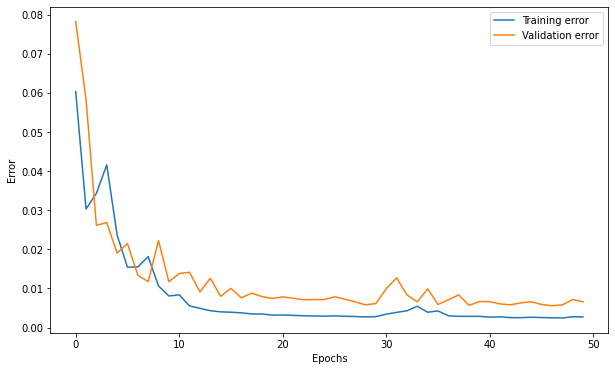

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training error')
plt.plot(history.history['val_loss'], label='Validation error')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.show()

In [ ]:
#scale back the prediction to orginal scale
y_pred = model.predict(x_test)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[2]*x_test.shape[1])

inv_new = np.concatenate( (y_pred, x_test[:,-9:] ) , axis =1)
inv_new = scaler.inverse_transform(inv_new)
final_pred = inv_new[:,0]

y_test = y_test.reshape( len(y_test), 1)

inv_new = np.concatenate( (y_test, x_test[:,-9:] ) ,axis = 1)
inv_new = scaler.inverse_transform(inv_new)
actual_pred = inv_new[:,0]

In [ ]:
final_pred = pd.DataFrame(final_pred, index = dataset.index[387:])

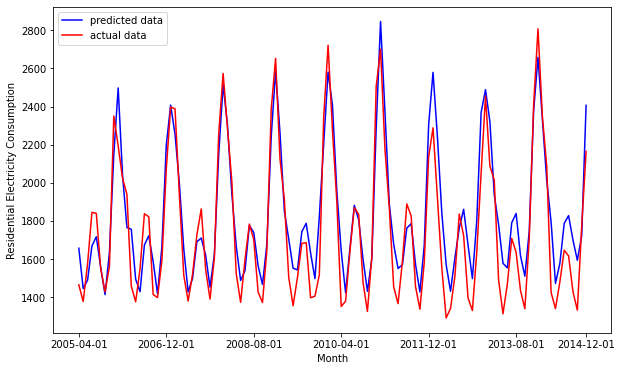

In [ ]:
#plot the prediction with actual data

plt.figure(figsize=(10,6))
plt.plot(final_pred[:], label = "predicted data",c = "b")
plt.plot(actual_pred[:],label = "actual data",c="r")
plt.xlabel("Month")
plt.xticks([0,20,40,60,80,100,116])
plt.ylabel("Residential Electricity Consumption")
plt.legend()

In [ ]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [ ]:
test_results = {}
test_results['mse'] = mean_squared_error(actual_pred, final_pred)
mse = test_results['mse']
test_results['rmse'] = np.sqrt(mse)
test_results['mae'] = mean_absolute_error(actual_pred, final_pred)
test_results['mape'] = mape(actual_pred, final_pred)
test_results

{'mae': 107.24059650173047,
 'mape': 6.165555712029253,
 'mse': 16952.93203069077,
 'rmse': 130.20342557202852}

In [ ]:
Results = pd.DataFrame.from_dict(test_results, orient='index', columns=['Error'])
Results.T

,mse,rmse,mae,mape
Error,16952.932031,130.203426,107.240597,6.165556
